In [1]:

from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))


In [2]:
from TimeSeriesUtils import rolling_forecast

In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
#from utils import get_channel
#from CustomTransformers import TimeSeriesFreqRegularization
#from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv("../datasets/ETH-USD_Open.csv", parse_dates=True, index_col="Datetime")
#df = df.asfreq("T")

In [5]:
df["Price"] = df["Open"]
df.drop(columns=["Open"], inplace=True)

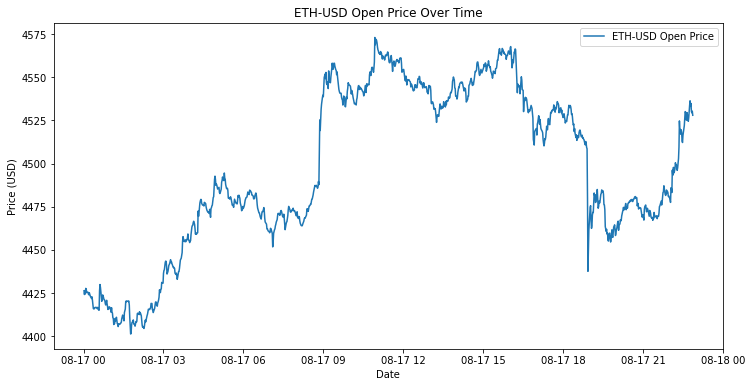

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='ETH-USD Open Price')
plt.title('ETH-USD Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Ver valores ¿Es estacionaria?

In [7]:
ADF_result = adfuller(df["Price"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.6951524852295587
p-value: 0.43361177714170085


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [8]:
df.loc[:,['values_diff']] = df["Price"].diff()
df_diff1 = df.copy()
#Eliminamos el nulo del inicio
df_diff1.dropna(inplace=True)

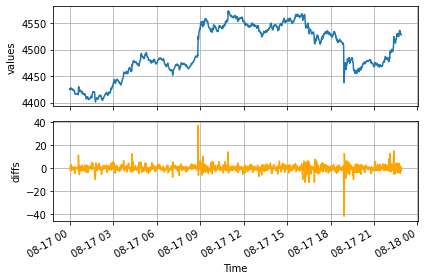

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df["Price"])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax1.grid()
ax2.plot(df['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.grid()
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

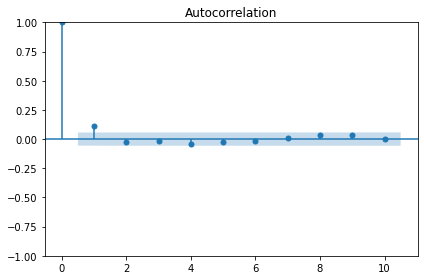

In [10]:
#El primer elemento es NaN, por eso no lo consideramos
plot_acf(df_diff1["values_diff"], lags=10)
plt.tight_layout()
plt.show()


¿Estamos antes un Moving Average de 1? Probemos PACF

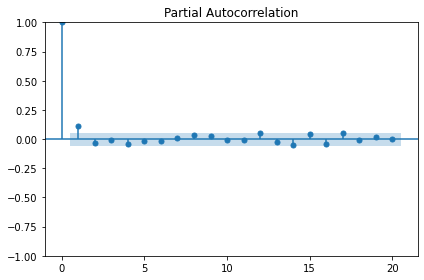

In [11]:
plot_pacf(df_diff1["values_diff"], lags=20)
plt.tight_layout()
plt.show()

No cae lentamente, ni tiene ciclos, parece mas bien un random walk

¿Le podemos ganar a alguna estrategia ingenua?

In [12]:
ldf = df_diff1.copy()


In [13]:
train_len = int(ldf.shape[0]*0.9)
test_len = ldf.shape[0] - train_len
train = ldf[:train_len]
test = ldf[train_len:]

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
print(f'TRAIN_LEN: {TRAIN_LEN}, HORIZON: {HORIZON}, WINDOW: {WINDOW}')

TRAIN_LEN: 1090, HORIZON: 122, WINDOW: 2


In [21]:
pred_mean       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'last')
order = (1, 0, 1)
seasonal_order = (0, 0, 0, 0)
pred_ARMA       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order=order, seasonal_order=seasonal_order)

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

In [22]:
test.loc[:, 'pred_mean']        = pred_mean
test.loc[:, 'pred_last_value']  = pred_last_value
test.loc[:, 'pred_ARMA']        = pred_ARMA

test.head()

,Price,values_diff,pred_mean,pred_last_value,pred_ARMA
Datetime,,,,,
2025-08-17 20:49:00+00:00,4476.868652,0.437012,0.046012,0.963867,0.266833
2025-08-17 20:50:00+00:00,4473.630859,-3.237793,0.046012,0.963867,-0.031985
2025-08-17 20:51:00+00:00,4474.573730,0.942871,0.043363,-3.237793,-0.407682
2025-08-17 20:52:00+00:00,4474.368652,-0.205078,0.043363,-3.237793,0.051763
2025-08-17 20:53:00+00:00,4474.156738,-0.211914,0.043958,-0.205078,-0.082527


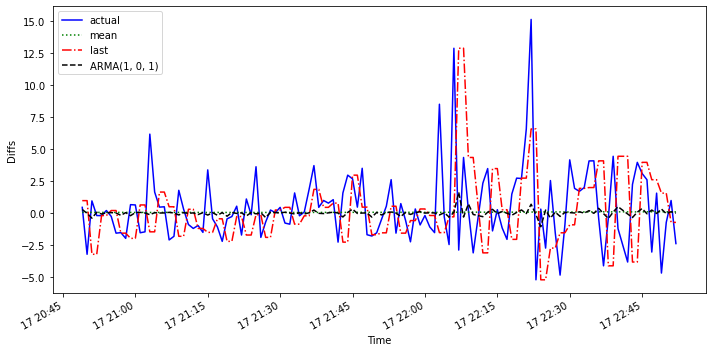

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label=f'ARMA{order}')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Que modelo dio mejor?

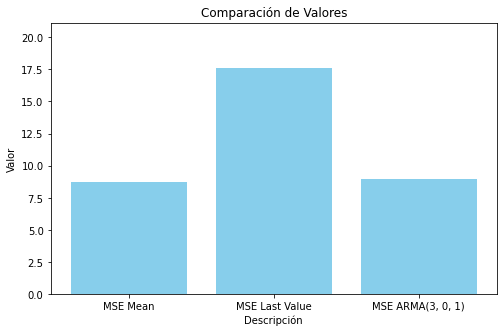

In [19]:
from sklearn.metrics import mean_squared_error
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_ARMA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', f'MSE ARMA{order}'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))
plt.bar(df_comm['Descripción'], df_comm['Valor'], color='skyblue')

plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

El resultado es peor que con métodos ingenuos...